**Install necessary packages**

In [ ]:
! pip install visualkeras

**Import all the necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import visualkeras
from sklearn.metrics import precision_score, recall_score, f1_score

**Configurations**

In [ ]:
# provide the path to the image data
GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks"
INPUT_DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'chest_xray')

# image configurations
LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = 128
IMAGE_CHANNEL = 1

# model configuration
MODEL_NAME = 'ChestXRay_CNN_Model'
EPOCH = 10
VERBOSE_MODE = True

**Function: Read images from files into arrays**

In [ ]:
def ReadImagesIntoArrays(image_dir):
    data = [] 
    for label in LABELS: 
        path = os.path.join(image_dir, label)
        image_label = LABELS.index(label)
        for imagefile in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path, imagefile), cv2.IMREAD_GRAYSCALE)
                resized_image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                data.append([resized_image, image_label])
            except Exception as e:
                print(e)
    return np.array(data)

**Read the image data**

In [ ]:
TrainingSet = ReadImagesIntoArrays(os.path.join(INPUT_DATA_PATH, 'train'))
ValidationSet = ReadImagesIntoArrays(os.path.join(INPUT_DATA_PATH, 'val'))
TestSet = ReadImagesIntoArrays(os.path.join(INPUT_DATA_PATH, 'test'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


**Analyze the training and validation data**

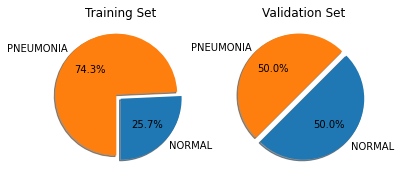

In [ ]:
trainingset_normal_counts = TrainingSet[:, -1].shape[0] - np.count_nonzero(TrainingSet[:, -1])
trainingset_pneumonia_counts = np.count_nonzero(TrainingSet[:, -1])
# plot
figure, axis = plt.subplots(1,2)
size = [trainingset_normal_counts, trainingset_pneumonia_counts]
explode = (0, 0.1)
axis[0].pie(size, explode=explode, labels=LABELS, autopct='%1.1f%%', shadow=True, startangle=270)
axis[0].set_title("Training Set")
validationset_normal_counts = ValidationSet[:, -1].shape[0] - np.count_nonzero(ValidationSet[:, -1])
validationset_pneumonia_counts = np.count_nonzero(ValidationSet[:, -1])
size = [validationset_normal_counts, validationset_pneumonia_counts]
explode = (0, 0.1)
axis[1].pie(size, explode=explode, labels=LABELS, autopct='%1.1f%%', shadow=True, startangle=225)
axis[1].set_title("Validation Set")
plt.show()

**Preprocess and normalize the data**

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for x, label in TrainingSet:
    x_train.append(x)
    y_train.append(label)
    
for x, label in ValidationSet:
    x_val.append(x)
    y_val.append(label)

for x, label in TestSet:
    x_test.append(x)
    y_test.append(label)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# resize data for deep learning 
x_train = x_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)
y_test = np.array(y_test)

**Augment the data to overfeat the data being imbalance**

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True)

datagen.fit(x_train)

**Construct the CNN model**

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.summary()

**Define the learning rate reduction based on the accuracy**

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=VERBOSE_MODE, factor=0.3, min_lr=0.000001)

**Train the CNN model**

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = EPOCH , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 248s 2s/step - loss: 0.4971 - accuracy: 0.8439 - val_loss: 36.0107 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 243s 1s/step - loss: 0.2752 - accuracy: 0.9011 - val_loss: 15.0868 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 241s 1s/step - loss: 0.1992 - accuracy: 0.9262 - val_loss: 3.4996 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 241s 1s/step - loss: 0.1909 - accuracy: 0.9371 - val_loss: 27.0450 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - 240s 1s/step - loss: 0.1703 - accuracy: 0.9402 - val_loss: 0.8710 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/10
163/163 [==============================] - 241s 1s/step - loss: 0.1708 - accuracy: 0.9423 - val_loss: 0.5577 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/10
163/163 [==============================] - 241s 1s

**Save the CNN model**

In [ ]:
model.save(os.path.join(GOOGLE_DRIVE_PATH, MODEL_NAME))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ChestXRay_CNN_Model/assets


**Load the CNN model**

In [ ]:
# model = load_model(os.path.join(GOOGLE_DRIVE_PATH, MODEL_NAME))

**Model visualization and summary**

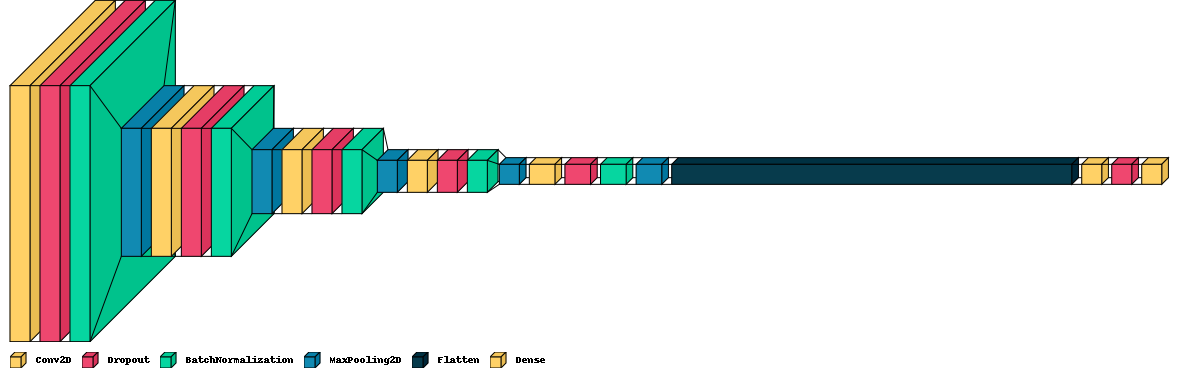

In [ ]:
visualkeras.layered_view(model, legend=True, scale_xy=2)
# model.summary()

**Make prediction from test data**

In [ ]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
y_hat = [0 if val < 0.5 else 1 for val in predictions]

**Analyze the result**

    Precision: 0.8473451327433629
    Recall: 0.982051282051282
    F1-Score: 0.9097387173396674


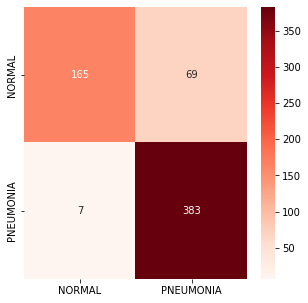

In [ ]:
# Report Precision, Recall, F1-Score
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat)
print(f"    Precision: {precision}")
print(f"    Recall: {recall}")
print(f"    F1-Score: {f1}")

# Confusion matrix
cm = confusion_matrix(y_test, y_hat)
cm_DF = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_DF, cmap="Reds", annot=True, fmt='', xticklabels=LABELS, yticklabels=LABELS)